<a href="https://colab.research.google.com/github/apoorwagupta/Multiclass-Classification-of-Colorectal-Cancer-Tissue/blob/main/RESNET_50_and_RESNET152V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
import torch
import cv2

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split

import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
  


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/cancerhistologydataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/base_dir') #Extracts the files into the /base_dir folder
zip_ref.close()

In [ ]:
len(os.listdir('/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'))

8

In [ ]:
base_dir = '/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'

In [ ]:
## Get labels of all classes in this dataset
img_labels = [i for i in os.listdir(base_dir) if not i.startswith('.')]
print('There are {} classes in this dataset:\n{}'.format(len(img_labels), img_labels))

There are 8 classes in this dataset:
['02_STROMA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '05_DEBRIS', '04_LYMPHO', '06_MUCOSA', '03_COMPLEX']


In [ ]:
tumor_files = glob(os.path.join(base_dir, img_labels[0], '*.tif'))
stroma_files = glob(os.path.join(base_dir, img_labels[1], '*.tif'))
complex_files = glob(os.path.join(base_dir, img_labels[2], '*.tif'))
lympho_files = glob(os.path.join(base_dir, img_labels[3], '*.tif'))
debris_files = glob(os.path.join(base_dir, img_labels[4], '*.tif'))
mucosa_files = glob(os.path.join(base_dir, img_labels[5], '*.tif'))
adipose_files = glob(os.path.join(base_dir, img_labels[6], '*.tif'))
empty_files = glob(os.path.join(base_dir, img_labels[7], '*.tif'))
img_files = [tumor_files, stroma_files, complex_files, lympho_files, debris_files, mucosa_files, adipose_files, empty_files]
total_files = [img for folder in img_files for img in folder]

In [ ]:
pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio(base_dir,output="datasetaftersplit",seed=35, ratio= (0.7,0.15,0.15), group_prefix = None)

Copying files: 5000 files [00:01, 3305.47 files/s]


In [ ]:
from tensorflow.keras.layers import Input

In [ ]:
from keras.models import load_model
from keras.models import Model

In [ ]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

In [ ]:
true_value = []
combined_model_pred = []
resnet_pred = []
inception_pred = []
resnet152V2_pred = []

Number of images in the train set :  3496
Number of images in the test set :  760


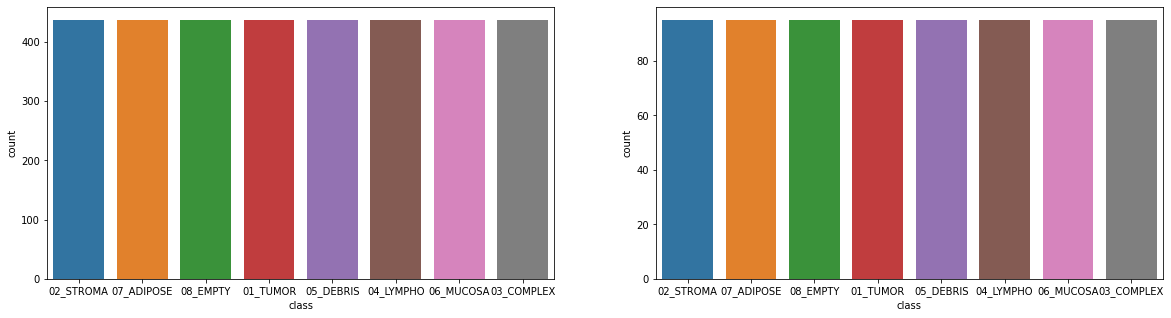

In [ ]:
root_path = '/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/datasetaftersplit/train/' #one more seg_train folder within
seg_test_folders = '/content/datasetaftersplit/test/'

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))


for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set : ",sum(quantity_te.values()))


plt.show()

# Image transformation:

1.Resize: Images  have a uniform size of 150x150px but in order to facilitate the CNN training process (MaxPooling), images will be resized to desired input size of the pretrained networks.

2. Random rotation and Random horizontal/vertical flip are used to avoid overfitting.Training and validation datasets will both be subject to augmentation, which will be used to randomly modify both datasets (TTA- test time augmentation ). The predictions will be based on the augmented images during the validation phase.

3.Normalization: The range [-1, 1] is used to normalise pixel values. All features will have the same range and contribute equally to the model after normalisation. The model will also be simpler to optimise and less sensitive to slight changes in weights.


In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True,
        vertical_flip = True) # horizontal flip
       

#### Image Data Generator

 Using this type of data augmentation we want to ensure that our network, when
trained, sees new variations of our data at each and every epoch.The ImageDataGenerator is not returning both the original data and the transformed data — the class only returns the randomly transformed 

* Step #1: An input batch of images is presented to the ImageDataGenerator .
* Step #2: The ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
* Step #3: The randomly transformed batch is then returned to the calling function.

this augmentation is done at training time (i.e., we are not generating these examples ahead of time/prior to training).

In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255,shear_range=0.2,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True,
        vertical_flip = True) # horizontal flip
      

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)
      

'acc' refers to accuracy of what was trained against. 'val_acc' refers to validation set. Note that val_acc refers to a set of samples that was not shown to the network during training and hence refers to how much your model works in general for cases outside the training set.

It is common for validation accuracy to be lower than accuracy. But ideally, you should strive to keep those values at the same level. If validation accuracy is much lower than accuracy, you are certainly over fitting (for exampe if the accuracy is 84 and validation accuracy is 77).

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

In [ ]:
#or resnet input sizeis 144

In [ ]:
# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory('/content/datasetaftersplit/train',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=42,
                                                    target_size=(144, 144))

test_generator = test_datagen.flow_from_directory("/content/datasetaftersplit/test",   
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=42,
                                                    target_size=(144, 144))


validation_generator = validation_datagen.flow_from_directory('/content/datasetaftersplit/val',   batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=42,
                                                    target_size=(144, 144))

Found 3496 images belonging to 8 classes.
Found 760 images belonging to 8 classes.
Found 744 images belonging to 8 classes.


In [ ]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 144, 144, 3)

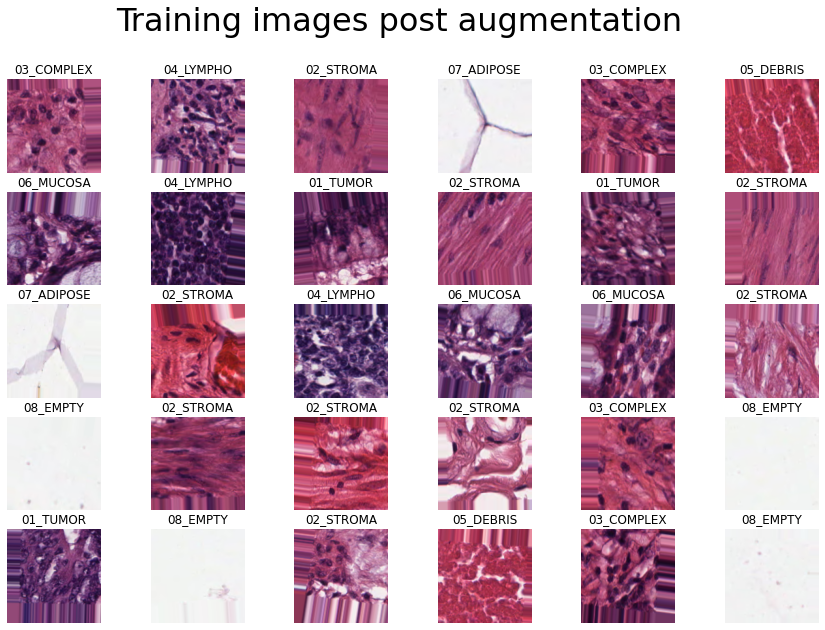

In [ ]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class names in a list
  
def plot_images(img,labels):
    fig= plt.figure(figsize=[15,10])
    for i in range(30):
        plt.subplot(5,6,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
        fig.suptitle('Training images post augmentation', fontsize = 32)  
plot_images(x,y)

#RESNET 50

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(144,144,3), classes=8)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.001,momentum= 0.7)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = keras.layers.Dense(100, activation='relu')(resnet50_x)
resnet50_x = Dense(256,activation='relu')(resnet50_x)#this would add a Fully Connected layer after the feature extraction layers of the ResNet.
resnet50_x = Dense(8,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = 50
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)


Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 0.8186 - acc: 0.7125
Epoch 1: val_acc improved from -inf to 0.12500, saving model to resnet50-saved-model-01-val_acc-0.12.hdf5
110/110 [==============================] - 35s 276ms/step - loss: 0.8186 - acc: 0.7125 - val_loss: 6.9991 - val_acc: 0.1250 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 0.3981 - acc: 0.8644
Epoch 2: val_acc did not improve from 0.12500
110/110 [==============================] - 28s 257ms/step - loss: 0.3981 - acc: 0.8644 - val_loss: 7.7726 - val_acc: 0.1250 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 0.3419 - acc: 0.8836
Epoch 3: val_acc improved from 0.12500 to 0.12634, saving model to resnet50-saved-model-03-val_acc-0.13.hdf5
110/110 [==============================] - 31s 281ms/step - loss: 0.3419 - acc: 0.8836 - val_loss: 7.6660 - val_acc: 0.1263 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - E

In [ ]:
#sgd optimiser used

In [ ]:
accuracy_score = resnet50_x_final_model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])

24/24 [==============================] - 4s 181ms/step - loss: 0.1585 - acc: 0.9516
[0.15854264795780182, 0.9516128897666931]
Accuracy: 95.1613%
Loss:  0.15854264795780182


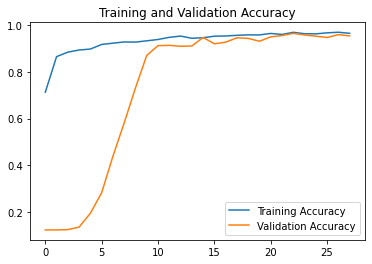

<Figure size 432x288 with 0 Axes>

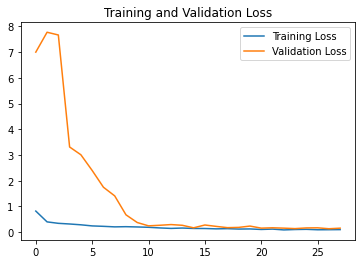

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(resnet50_history, 'resnet50_model')

In [ ]:
resnet_best_model = resnet50_x_final_model

In [ ]:
from collections import Counter

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
resnet_pred = []

for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
       
        
        #resnet50
        img = cv2.resize(cv2.imread(path),(144,144))
        img_normalized = img/255
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
    
       
        #giving  inception_image_prediction high priority if they all predict something different
        image_prediction = mode([ resnet_50_image_prediction,])                                  
        combined_model_pred.append(image_prediction)

Model Accuracy 0.7894736842105263
              precision    recall  f1-score   support

    01_TUMOR       0.65      0.95      0.77        95
   02_STROMA       0.68      0.84      0.75        95
  03_COMPLEX       0.74      0.34      0.46        95
   04_LYMPHO       0.92      0.62      0.74        95
   05_DEBRIS       0.55      0.66      0.60        95
   06_MUCOSA       0.95      0.94      0.94        95
  07_ADIPOSE       0.99      0.98      0.98        95
    08_EMPTY       0.99      0.99      0.99        95

    accuracy                           0.79       760
   macro avg       0.81      0.79      0.78       760
weighted avg       0.81      0.79      0.78       760



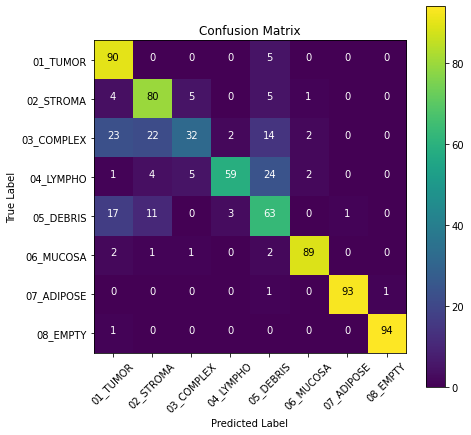

In [ ]:
clf_report(true_value, resnet_pred)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import ResNet152V2

In [ ]:
import keras.applications.resnet
from tensorflow.keras.optimizers import SGD


In [ ]:

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory('/content/datasetaftersplit/train',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=32,
                                                    target_size=(224, 224)) #target size is 224 this

test_generator = test_datagen.flow_from_directory("/content/datasetaftersplit/test",   
                                                     batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=32,
                                                    target_size=(224, 224))


validation_generator = validation_datagen.flow_from_directory('/content/datasetaftersplit/val',   batch_size=32,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=32,
                                                    target_size=(224, 224))

Found 3496 images belonging to 8 classes.
Found 760 images belonging to 8 classes.
Found 744 images belonging to 8 classes.


In [ ]:
ResNet152V2_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=8)

for layers in ResNet152V2_model.layers:
    layers.trainable=True

opt = SGD(lr=0.0001,momentum= 0.7)
resnet152V2_x = Flatten()(ResNet152V2_model.output)
resnet152V2_x = Dense(256,activation='relu')(resnet152V2_x)
resnet152V2_x = Dense(8,activation='softmax')(resnet152V2_x)
resnet152V2_x_final_model = Model(inputs=ResNet152V2_model.input, outputs=resnet152V2_x)
resnet152V2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = 50
resnet_filepath = 'resnet152V2'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet152V2_history = resnet152V2_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 1.4441 - acc: 0.5183
Epoch 1: val_acc improved from -inf to 0.59812, saving model to resnet152V2-saved-model-01-val_acc-0.60.hdf5
110/110 [==============================] - 117s 939ms/step - loss: 1.4441 - acc: 0.5183 - val_loss: 1.1323 - val_acc: 0.5981 - lr: 1.0000e-04
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 0.8173 - acc: 0.7288
Epoch 2: val_acc improved from 0.59812 to 0.76344, saving model to resnet152V2-saved-model-02-val_acc-0.76.hdf5
110/110 [==============================] - 100s 906ms/step - loss: 0.8173 - acc: 0.7288 - val_loss: 0.7113 - val_acc: 0.7634 - lr: 1.0000e-04
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 0.6660 - acc: 0.7760
Epoch 3: val_acc improved from 0.76344 to 0.80511, saving model to resnet152V2-saved-model-03-val_acc-0.81.hdf5
110/110 [==============================] - 98s 893ms/step - loss: 0.6660 - acc: 0.7760 - val_loss: 0.5988 - va

In [ ]:
resnet152V2_best_model = resnet152V2_x_final_model

In [ ]:
accuracy_score = resnet152V2_x_final_model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])

24/24 [==============================] - 10s 396ms/step - loss: 0.2593 - acc: 0.9099
[0.2593177556991577, 0.9099462628364563]
Accuracy: 90.9946%
Loss:  0.2593177556991577


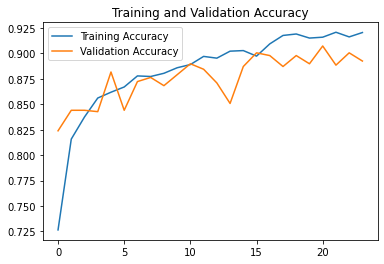

<Figure size 432x288 with 0 Axes>

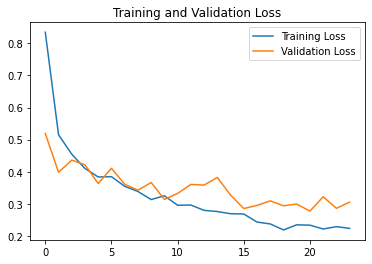

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(resnet152V2_history, 'resnet152V2')

In [ ]:
from collections import Counter

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []


resnet152V2_pred = []
for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
       
        
        
        #resnet152V2
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255
        resnet_152V2_image_prediction = np.argmax(resnet152V2_best_model.predict(np.array([img_normalized])))
        resnet152V2_pred.append(resnet_152V2_image_prediction)
       
       
       
        #giving  inception_image_prediction high priority if they all predict something different
        image_prediction = mode([ resnet_50_image_prediction,resnet_152V2_image_prediction])                                  
        combined_model_pred.append(image_prediction)

Model Accuracy 0.7684210526315789
              precision    recall  f1-score   support

    01_TUMOR       0.71      0.94      0.81        95
   02_STROMA       0.65      0.63      0.64        95
  03_COMPLEX       0.60      0.03      0.06        95
   04_LYMPHO       0.83      0.88      0.86        95
   05_DEBRIS       0.54      0.81      0.65        95
   06_MUCOSA       0.87      0.95      0.91        95
  07_ADIPOSE       0.95      0.93      0.94        95
    08_EMPTY       0.95      0.98      0.96        95

    accuracy                           0.77       760
   macro avg       0.76      0.77      0.73       760
weighted avg       0.76      0.77      0.73       760



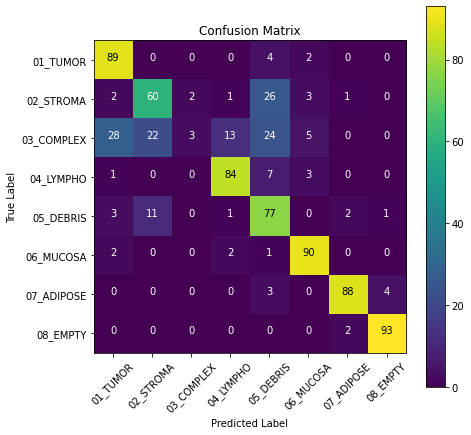

In [ ]:
clf_report(true_value, resnet152V2_pred)